# Create a Mask Variable Based on a Polygon
## Lejo Flores
### 2021-05-31

This notebook is a workflow for creating an indicator variable (an array of 1s and NaNs) on a WRF grid that masks an area of interest like a watershed, county, state, etc. This is a common use-case in which you might be interested in isolating outputs from a WRF simulation to a particular watershed. 

This notebook assumes that you already have a polygon file of your area of interest in a geographic projection, preferrably projected onto a spherical Earth like WRF's grid. Note that this is not straightforward because WRF grids are curvilinear grids, not rectilinear. That is, in terms of a latitute and longitude, their dimensions cannot be reduced to 1-D arrays (although they are logically rectangular in their own projection). As such, it is difficult to find a resource that can correctly project the polygon to intersect with the WRF grid onto WRF's native projection, which is set in the namelist.wps file. There are other ways to do this, but the workflow below allows the user to be in the loop just enough to ensure that you get what you want. 

The workaround presented here requires QGIS and a few steps in that platform described below. Essentially, the workflow is broken into the following steps:
1. Open the WRF geo_em file created by WPS,
2. Use the geo_em files to create a CSV file where each record contains the latitude, longitude, land use, land mask, and a (created) unique pixel ID for each WRF grid point,
3. Import that CSV file into QGIS as a point coverage, with each point being a point on the grid
4. Intersect that point coverage with the polygon of interest to be masked and export it as a CSV file with an additional set of attributes (inherited from the polygon file) that indicate whether or not each WRF grid point is within the masked area. Those additional attributes will be set to NaN for those grid points that do not intersect with the masking polygon,
5. Use `pandas` to sort the CSV file from step 4. by pixel_id and select a column that corresponds to the additional attributes inhereted from the polygon,
6. Reshape the a variable from the `pandas` dataframe into the original grid shape (this will now be the mask) and use it to mask elevation, land use, and land/water, 
7. Export the variables from step 6. to a NetCDF file that can subsequently be used to mask other, time-varying WRF variables. 

## 1. Import Libraries Needed and Set Variable Names

In [1]:
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_geo_em_file = 'geo_em.d01.nc' # Geo_em file from WPS
output_csv_file = 'id_wrf_d01.csv' # CSV file that will be created from the info in the geo_em file
masked_csv_file = 'id_wrf_d01_SRB_point.csv' # CSV file that will be created by QGIS (see steps below)
output_nc_file = 'id_wrf_d01_SRB_mask.nc' # The output NetCDF file that will be created with masks

mask_sort_var = 'HUC4' # An attribute that is inherited from the polygon file when you 
                       # perform the intersection. NOTE: This may change based on the polygon you 
                       # intersect, but should be numeric. It may be a Hydrologic Unit Code (as here),
                       # FIPS code for counties and states, zip code, etc. 

## 2. Open the Dataset, Get Variables, and Export CSV File

In [2]:
ds = xr.open_dataset(input_geo_em_file)
ds

<xarray.Dataset>
Dimensions:     (Time: 1, land_cat: 21, month: 12, num_urb_params: 132, soil_cat: 16, south_north: 289, south_north_stag: 290, west_east: 339, west_east_stag: 340)
Dimensions without coordinates: Time, land_cat, month, num_urb_params, soil_cat, south_north, south_north_stag, west_east, west_east_stag
Data variables:
    Times       (Time) |S19 ...
    XLAT_M      (Time, south_north, west_east) float32 ...
    XLONG_M     (Time, south_north, west_east) float32 ...
    XLAT_V      (Time, south_north_stag, west_east) float32 ...
    XLONG_V     (Time, south_north_stag, west_east) float32 ...
    XLAT_U      (Time, south_north, west_east_stag) float32 ...
    XLONG_U     (Time, south_north, west_east_stag) float32 ...
    CLAT        (Time, south_north, west_east) float32 ...
    CLONG       (Time, south_north, west_east) float32 ...
    MAPFAC_M    (Time, south_north, west_east) float32 ...
    MAPFAC_V    (Time, south_north_stag, west_east) float32 ...
    MAPFAC_U    (Time, south_north, west_east_stag) float32 ...
    MAPFAC_MX   (Time, south_north, west_east) float32 ...
    MAPFAC_VX   (Time, south_north_stag, west_east) float32 ...
    MAPFAC_UX   (Time, south_north, west_east_stag) float32 ...
    MAPFAC_MY   (Time, south_north, west_east) float32 ...
    MAPFAC_VY   (Time, south_north_stag, west_east) float32 ...
    MAPFAC_UY   (Time, south_north, west_east_stag) float32 ...
    E           (Time, south_north, west_east) float32 ...
    F           (Time, south_north, west_east) float32 ...
    SINALPHA    (Time, south_north, west_east) float32 ...
    COSALPHA    (Time, south_north, west_east) float32 ...
    LANDMASK    (Time, south_north, west_east) float32 ...
    XLAT_C      (Time, south_north_stag, west_east_stag) float32 ...
    XLONG_C     (Time, south_north_stag, west_east_stag) float32 ...
    SINALPHA_U  (Time, south_north, west_east_stag) float32 ...
    COSALPHA_U  (Time, south_north, west_east_stag) float32 ...
    SINALPHA_V  (Time, south_north_stag, west_east) float32 ...
    COSALPHA_V  (Time, south_north_stag, west_east) float32 ...
    LANDUSEF    (Time, land_cat, south_north, west_east) float32 ...
    LU_INDEX    (Time, south_north, west_east) float32 ...
    HGT_M       (Time, south_north, west_east) float32 ...
    SOILTEMP    (Time, south_north, west_east) float32 ...
    SOILCTOP    (Time, soil_cat, south_north, west_east) float32 ...
    SCT_DOM     (Time, south_north, west_east) float32 ...
    SOILCBOT    (Time, soil_cat, south_north, west_east) float32 ...
    SCB_DOM     (Time, south_north, west_east) float32 ...
    ALBEDO12M   (Time, month, south_north, west_east) float32 ...
    GREENFRAC   (Time, month, south_north, west_east) float32 ...
    LAI12M      (Time, month, south_north, west_east) float32 ...
    SNOALB      (Time, south_north, west_east) float32 ...
    SLOPECAT    (Time, south_north, west_east) float32 ...
    CON         (Time, south_north, west_east) float32 ...
    VAR         (Time, south_north, west_east) float32 ...
    OA1         (Time, south_north, west_east) float32 ...
    OA2         (Time, south_north, west_east) float32 ...
    OA3         (Time, south_north, west_east) float32 ...
    OA4         (Time, south_north, west_east) float32 ...
    OL1         (Time, south_north, west_east) float32 ...
    OL2         (Time, south_north, west_east) float32 ...
    OL3         (Time, south_north, west_east) float32 ...
    OL4         (Time, south_north, west_east) float32 ...
    VAR_SSO     (Time, south_north, west_east) float32 ...
    LAKE_DEPTH  (Time, south_north, west_east) float32 ...
    URB_PARAM   (Time, num_urb_params, south_north, west_east) float32 ...
    IMPERV      (Time, south_north, west_east) float32 ...
    CANFRA      (Time, south_north, west_east) float32 ...
Attributes:
    TITLE:                           OUTPUT FROM GEOGRID V3.8.1
    SIMULATION_START_DATE:           0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION:        34

In [3]:
lat = ds['XLAT_M'].isel(Time=0).values
lon = ds['XLONG_M'].isel(Time=0).values

landmask = ds['LANDMASK'].isel(Time=0).values
elev = ds['HGT_M'].isel(Time=0).values
lu_index = ds['LU_INDEX'].isel(Time=0).values
pixel_id = np.arange(lat.size)

In [4]:
output = np.stack((lat.flatten(), lon.flatten(), elev.flatten(), 
                   lu_index.flatten(), landmask.flatten(), pixel_id),axis=1)

In [5]:
np.savetxt(output_csv_file, output, fmt=['%f','%f','%f','%d','%d','%d'], delimiter=',', 
           comments='', header='latitude, longitude, HGT_M, LU_INDEX, LANDMASK, pixel_id')

## 3. QGIS Steps

The next steps of this workflow occur in QGIS. The steps are as follows:
1. Import the csv file exported in the cell above as a point coverage using the Data Layer Manager. Select EPSG:3857, which is a CRS on a spherical globe (like WRF) and a WGS84 datum.
2. Create a spatial index for this coverage by going to Vector -> Data Management Tools -> Create Spatial Index.
3. Add the polygon coverage that you will intersect to create a mask. Transform the CRS to match the point coverage from step 1. 
4. Intersect features of the point coverage with the polygon defining the watershed boundaries, using the keep first features: 
    a. Go to Vector -> Data Management Tools -> Join Attributes By Location
    b. Select the following options
      - Base Layer = point coverage created in step 1.
      - Join Layer = polygon coverage from step 3. 
      - Geometric predicate = intersects
      - Join type = select "Take attributes from the first matching feature only"
      - Joined layer = leave as a temporary layer or create a new coverage
      - Click run (if you skipped step 2. you may get a "No spatial index" warning, which will cause the operation to execute more slowly)
5. After step 4 is complete, inspect the Attribute Table of the joined layer by right clicking it in the Layers window and selecting "Open Attribute Table." 
6. Further verify the created masky by doing the following: 
    a. Right click the layer and select properties. 
    b. Select "Symbology" in the dialog window
    c. At the top, select the drop down menu and select "Categorized"
    d. In Value select HUC4 (or any other attribute that should have been joined from the dialog box. Note this should be set as the `mask_sort_var` set above) 
    e. Click "Classify" at the bottom. 
    f. Click "Apply" and "OK." The result should be that the point coverage is one color within the watershed/polygon and another color everywhere outside it. 
7. Now export the attribute table as a CSV file by right clicking the joined layer and selecting "Export -> Save Features As..." from the pop-up.
8. In the export window as format select "Comma Separated Variable," enter the name and location of the output file name (this should correspond to `masked_csv_file` above), and click "OK."

## 4. Read In CSV File Exported from QGIS

In [6]:
df = pd.read_csv(masked_csv_file,low_memory=False)
df

,latitude,longitude,HGT_M,LU_INDEX,LANDMASK,pixel_id,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC4,Name,Shape_Leng,Shape_Area
0,41.160542,-116.238998,2145.358887,10,1,9618,{0EAB6775-0DE6-4F8F-AA2C-C4339ACB0A5C},NaN,NaN,NaN,NaN,2013/01/18,NaN,22958488.0,92909.79,"ID,WY",1704.0,Upper Snake,26.012027,10.296656
1,41.186977,-116.275467,2072.638916,10,1,9956,{0EAB6775-0DE6-4F8F-AA2C-C4339ACB0A5C},NaN,NaN,NaN,NaN,2013/01/18,NaN,22958488.0,92909.79,"ID,WY",1704.0,Upper Snake,26.012027,10.296656
2,41.187477,-116.239670,2002.616211,10,1,9957,{0EAB6775-0DE6-4F8F-AA2C-C4339ACB0A5C},NaN,NaN,NaN,NaN,2013/01/18,NaN,22958488.0,92909.79,"ID,WY",1704.0,Upper Snake,26.012027,10.296656
3,41.187984,-116.203873,2012.787109,10,1,9958,{0EAB6775-0DE6-4F8F-AA2C-C4339ACB0A5C},NaN,NaN,NaN,NaN,2013/01/18,NaN,22958488.0,92909.79,"ID,WY",1704.0,Upper Snake,26.012027,10.296656
4,41.188469,-116.168060,2117.854492,10,1,9959,{0EAB6775-0DE6-4F8F-AA2C-C4339ACB0A5C},NaN,NaN,NaN,NaN,2013/01/18,NaN,22958488.0,92909.79,"ID,WY",1704.0,Upper Snake,26.012027,10.296656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97966,48.002579,-108.052673,798.280273,12,1,97966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97967,48.000393,-108.012558,774.176880,12,1,97967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97968,47.998196,-107.972458,761.256348,12,1,97968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97969,47.995983,-107.932343,749.313354,12,1,97969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.a. Sort Based on `pixel_id`

Note that when QGIS performs the intersection, the attribute table will be sorted differently so that all the features that intersect appear toward the top of the attribute table. It is essential to re-sort the data frame based in order to recover the orientation of the original grid, which is why we created `pixel_id` in the first place. 

In [7]:
df2 = df.sort_values('pixel_id')
df2

,latitude,longitude,HGT_M,LU_INDEX,LANDMASK,pixel_id,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,States,HUC4,Name,Shape_Leng,Shape_Area
30992,40.251755,-120.665771,1880.548340,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30993,40.253700,-120.630600,1976.477539,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30994,40.255638,-120.595428,1989.326904,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30995,40.257568,-120.560242,1946.802002,1,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30996,40.259487,-120.525055,1717.188965,1,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97966,48.002579,-108.052673,798.280273,12,1,97966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97967,48.000393,-108.012558,774.176880,12,1,97967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97968,47.998196,-107.972458,761.256348,12,1,97968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97969,47.995983,-107.932343,749.313354,12,1,97969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.b. Create the Masked Grid and Verify Visually

In this case, the mask should correspond to the Snake River Basin

In [8]:
Mask_grid = df2[mask_sort_var].values
Mask_grid = np.where(np.isnan(Mask_grid),Mask_grid,1.0)
Mask_grid = Mask_grid.reshape((289,339))

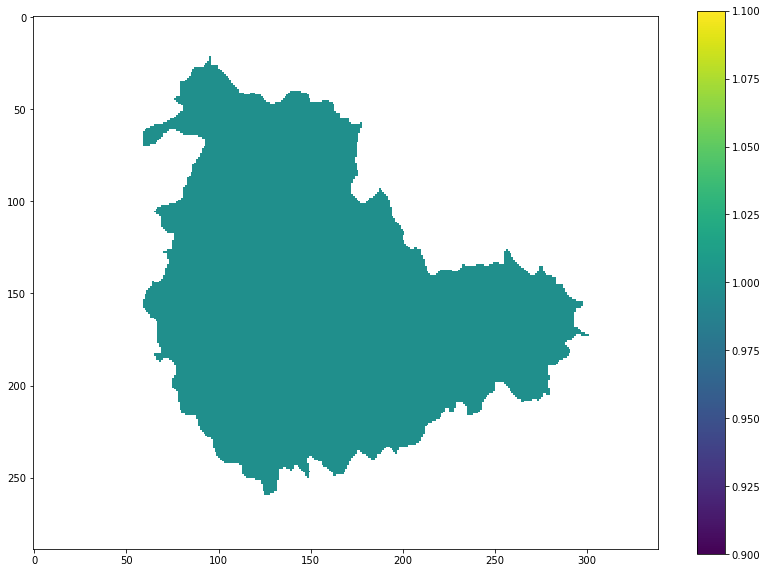

In [9]:
plt.figure(figsize=(14,10))
plt.imshow(np.flipud(Mask_grid))
plt.colorbar()

## 5. Create an `xArray` Dataset from the Mask and Save to a NetCDF File

In [10]:
# Create the dataset
ds_mask = xr.Dataset(
        data_vars=dict(
            SHAPE_MASK=(['south_north','west_east'], Mask_grid),
            ELEV=(['south_north','west_east'], np.multiply(elev, Mask_grid)),
            LANDUSE=(['south_north','west_east'], np.multiply(lu_index, Mask_grid)),
            LANDWATER=(['south_north','west_east'], np.multiply(np.where(landmask==0.0,np.nan,landmask), Mask_grid)),
        ),
        coords=dict(
            XLONG=(['south_north','west_east'], lon),
            XLAT=(['south_north','west_east'], lat)
        ),
        attrs=dict(description='Features of geo_em file masked to shape'),
    )

# Create attributes for each variable
ds_mask['SHAPE_MASK'].attrs = {'long_name': 'Masked Area',
                        'units': '-',
                        'description': 'Area in WRF domain masked by user shapefile'}

ds_mask['ELEV'].attrs = {'long_name': 'Elevation',
                        'units': 'm',
                        'description': 'Elevation from WRF HGT_M field'}

ds_mask['LANDUSE'].attrs = {'long_name': 'Land use/Land Cover',
                        'units': '-',
                        'description': 'Land use/land cover for masked area from WRF LU_INDEX field'}

ds_mask['LANDWATER'].attrs = {'long_name': 'Land Indicator',
                        'units': '-',
                        'description': 'Land (not water) indicator for masked area from WRF LANDMASK field'}

ds_mask['XLONG'].attrs = ds['XLONG_M'].attrs
ds_mask['XLAT'].attrs = ds['XLAT_M'].attrs

# Export it to a NetCDF file
ds_mask.to_netcdf(output_nc_file)

## 5. Visually Verify Elevation, Land Use, and Land/Water Indicator

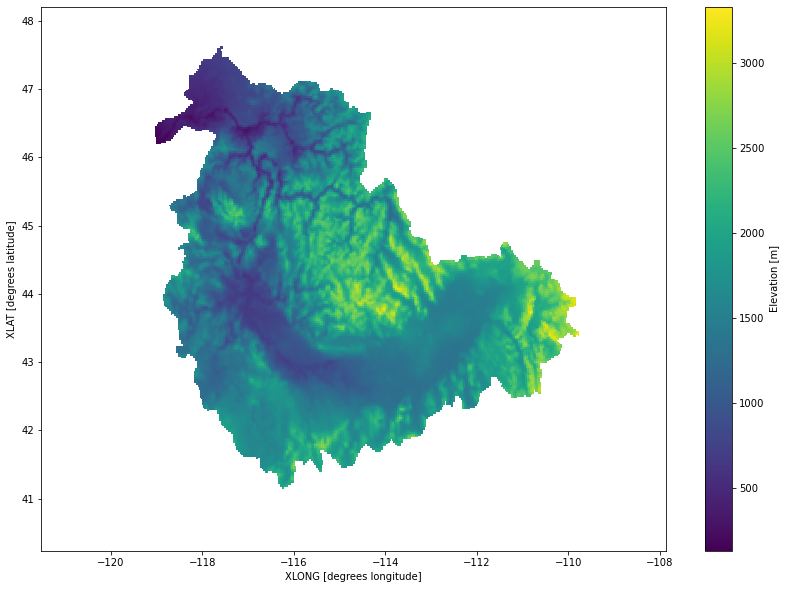

In [11]:
ds_mask['ELEV'].plot(x='XLONG',y='XLAT',figsize=(14,10))

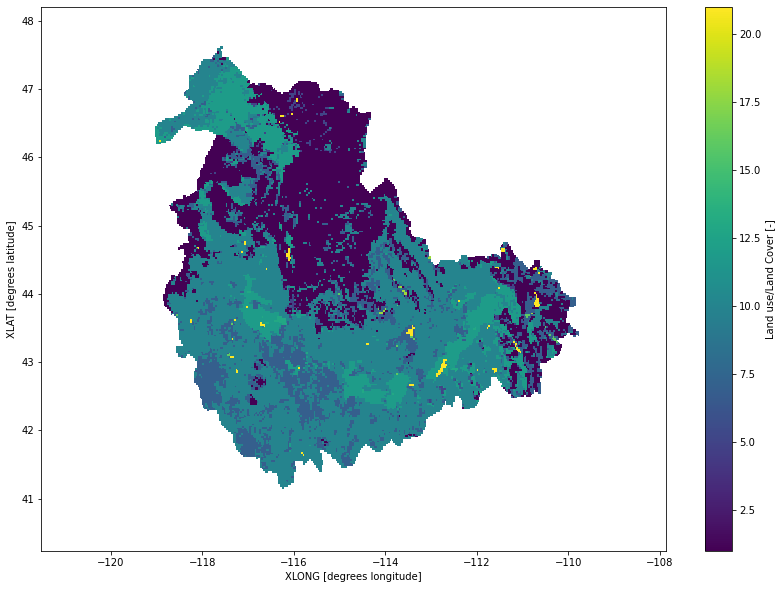

In [12]:
ds_mask['LANDUSE'].plot(x='XLONG',y='XLAT',figsize=(14,10))

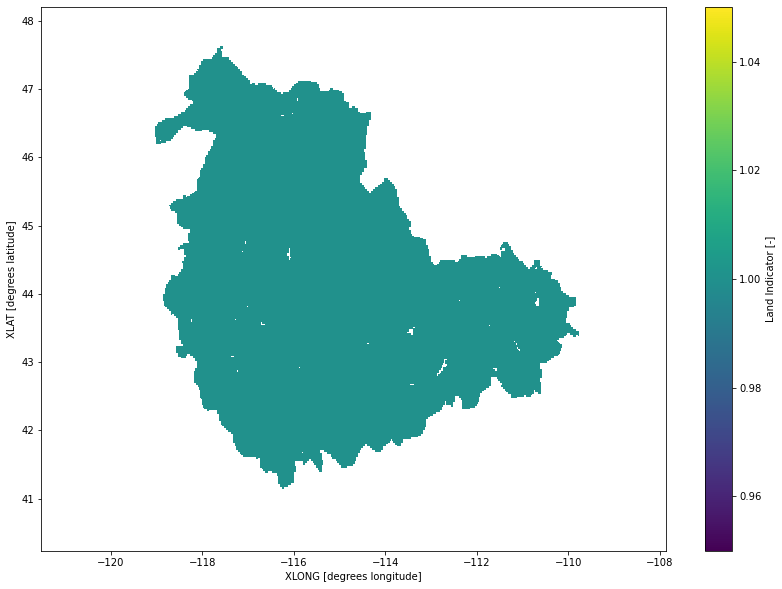

In [13]:
ds_mask['LANDWATER'].plot(x='XLONG',y='XLAT',figsize=(14,10))